# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import markdown
from bs4 import BeautifulSoup
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time

# magic word for producing visualizations in notebook
%matplotlib inline

# Sources consulted:
# Katba, Caroline. "Identifying Customer Segments." On Women and Data, 2018. https://katba-caroline.com/identifying-customer-segments-for-mail-order-sales-company-with-pca-and-kmeans-clustering/
# Kusainov, Talgat. "Project: Identify Customer Segments." Github, 2018. https://github.com/Kusainov/udacity-identify-customers-segments/blob/master/Identify_Customer_Segments.ipynb
# Tahmasbi, Amir. "Project: Identify Customer Segments." Github, 2018. https://github.com/atahmasb/Identify-Customer-Segments-with-Arvato/blob/master/Identify_Customer_Segments.ipynb
# Wang, Bin. "Identify Customer Segments." Github, 2018. https://github.com/bin-wang-sh/Identify-Customer-Segments/blob/master/Identify_Customer_Segments.ipynb
# Wang, Shuo. "Identify Customer Segments." Github, 2018. https://github.com/swang13/identify-customer-segments/blob/master/Identify_Customer_Segments.ipynb


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep = ';')


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Describe data
azdias.describe()

# Note: 891221 rows (persons), 81 columns (demographics), some missing data

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
# Identify missing or unknown data values and convert them to NaNs.

start_time = time.time()

print(azdias.isnull().sum().sum())

for item in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[item]['missing_or_unknown']
    missing_or_unknown_formatted = missing_or_unknown.strip('[').strip(']').split(sep = ',')
    missing_or_unknown_new = [int(entry) if (entry != 'X' and entry != 'XX' and entry != '') else entry for entry in missing_or_unknown_formatted]
    if missing_or_unknown_new != ['']:
        azdias = azdias.replace({feat_info.iloc[item]['attribute']: missing_or_unknown_new}, np.nan)

print(azdias.isnull().sum().sum())

print('Run time: %s seconds' % (time.time() - start_time))

4896838
8373929
Run time: 83.57025456428528 seconds


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

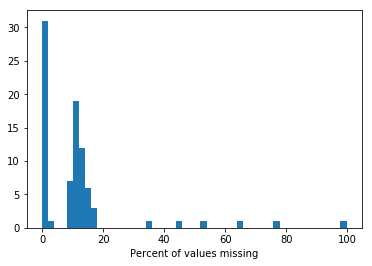

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

percent_missing = (azdias.isna().sum() / azdias.shape[0]) * 100

plt.hist(percent_missing, bins = 50)
plt.xlabel('Percent of values missing')
plt.show()


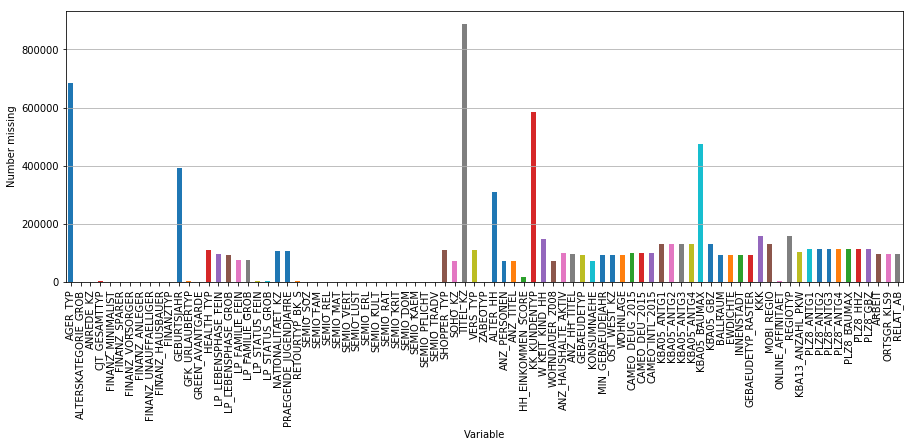

In [8]:
# Investigate patterns in the amount of missing data in each column.

azdias.isna().sum().plot.bar(figsize = (15,5)).grid(axis = 'y')
plt.xlabel('Variable')
plt.ylabel('Number missing')
plt.show()


In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outliers = percent_missing[percent_missing > 20]
print(outliers)

azdias.drop(outliers.index.tolist(), axis = 1, inplace = True)

# Outlier columns: AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX


AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Answer: Out of 81 total columns, six were removed (AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and KBA05_BAUMAX), using a threshold of 20%. As shown in the graph these six variables are significant outliers in the data: in contrast, other variables have no missing values or are missing around 5%. One way to describe the outliers is that these six variables have more than twice as many missing values as the variables-with-the-most-missing-values among the remaining 75.**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

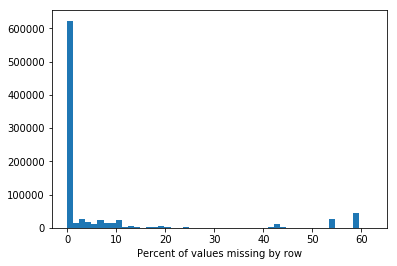

In [10]:
# How much data is missing in each row of the dataset?

percent_missing_rows = (azdias.isna().sum(axis = 1) / azdias.shape[1]) * 100

plt.hist(percent_missing_rows, bins = 50)
plt.xlabel('Percent of values missing by row')
plt.show()


In [11]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold_value = 25

azdias_split_1 = azdias[azdias.isnull().sum(axis = 1) <= threshold_value]
azdias_split_2 = azdias[azdias.isnull().sum(axis = 1) > threshold_value]


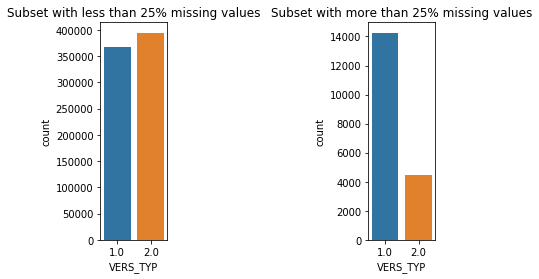

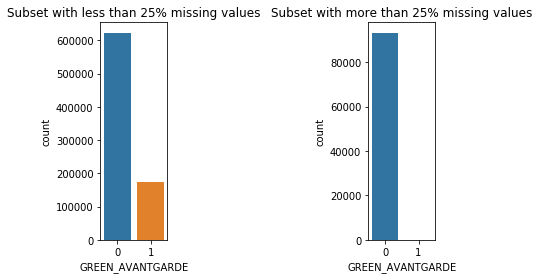

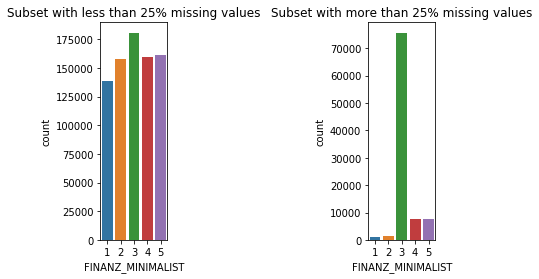

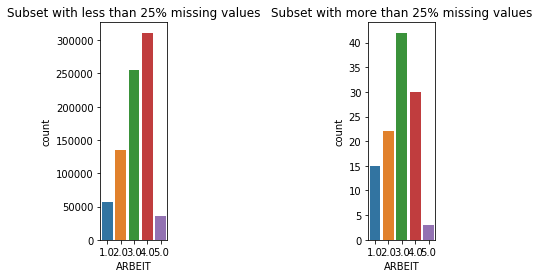

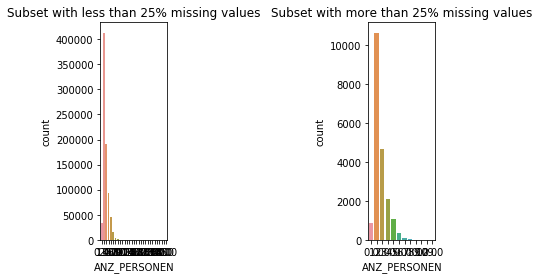

In [12]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

random.seed(23)
random_values = random.sample(range(1, azdias.shape[1]), 5)

for i in range(5):
    figure, axs = plt.subplots(1, 2)
    figure.subplots_adjust(hspace = 3, wspace = 3)
    
    sns.countplot(azdias_split_1[azdias.columns[random_values[i]]], ax=axs[0])
    axs[0].set_title('Subset with less than {}% missing values'.format(threshold_value))
    
    sns.countplot(azdias_split_2[azdias.columns[random_values[i]]], ax=axs[1])
    axs[1].set_title('Subset with more than {}% missing values'.format(threshold_value))


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer: The answer seems to be different depending on the specific variable. Some of the variables are distributed similarly in the "subset with few missing values" compared to the "subset with many missing values", while others are distributed very differently. For example, ARBEIT seems to be (roughly) similarly distributed, while FINANZ_MINIMALIST seems to be distributed differently. We can probably assume that the observations with many missing values and the observations with few missing values are different in at least some respects.**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [13]:
# How many features are there of each data type?
feat_info.type.value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [14]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_variables = feat_info['type'] == 'categorical'

binary_variables = []
multilevel_variables = []
for i in feat_info[categorical_variables].iloc[:,0]:
    if i not in outliers:
        if (len(azdias_split_1[i].unique()) == 2):
            binary_variables.append(i)
        else:
            multilevel_variables.append(i)
        
print('Binary variables: {}'.format(binary_variables))
print('Multilevel variables: {}'.format(multilevel_variables))


Binary variables: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multilevel variables: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [15]:
for i in binary_variables:
    print('Values for binary variables: {} {}'.format(i, azdias_split_1[i].unique()))


Values for binary variables: ANREDE_KZ [2 1]
Values for binary variables: GREEN_AVANTGARDE [0 1]
Values for binary variables: SOHO_KZ [ 1.  0.]
Values for binary variables: OST_WEST_KZ ['W' 'O']


In [16]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_split_1_reencode = azdias_split_1.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}})

# Note: keep and use get_dummies for multilevel variables 
azdias_split_1_dummies = pd.get_dummies(azdias_split_1_reencode, columns = multilevel_variables)
print(azdias_split_1_dummies.columns)


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=195)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**For now, I kept all the categorical features. I created separate lists of binary and multilevel variables. For the one binary variable (OST_WEST_KZ) that had non-numeric values, I replaced the non-numeric values with numeric values (0 and 1 for 'W' and 'O' respectively). I used get_dummies to create dummy variables for all multilevel variables.**

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [17]:
# Check Data_Dictionary.md
data_dictionary = markdown.markdown(open('Data_Dictionary.md').read())
print("".join(BeautifulSoup(data_dictionary).findAll(text = True)))


Data Dictionary for Identify Customer Segments Data
Introduction
The data for this project consist of two files:

Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.
Table of Contents

Person-level features
Household-level features
Building-level features
RR4 micro-cell features
RR3 micro-cell features
Postcode-level features
RR1 neighborhood features
PLZ8 ma

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/conda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [ ]:
# From Data_Dictionary.md

#1.18. PRAEGENDE_JUGENDJAHRE
#Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
#- -1: unknown
#-  0: unknown
#-  1: 40s - war years (Mainstream, E+W)
#-  2: 40s - reconstruction years (Avantgarde, E+W)
#-  3: 50s - economic miracle (Mainstream, E+W)
#-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
#-  5: 60s - economic miracle (Mainstream, E+W)
#-  6: 60s - generation 68 / student protestors (Avantgarde, W)
#-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
#-  8: 70s - family orientation (Mainstream, E+W)
#-  9: 70s - peace movement (Avantgarde, E+W)
#- 10: 80s - Generation Golf (Mainstream, W)
#- 11: 80s - ecological awareness (Avantgarde, W)
#- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
#- 13: 80s - Swords into ploughshares (Avantgarde, E)
#- 14: 90s - digital media kids (Mainstream, E+W)
#- 15: 90s - ecological awareness (Avantgarde, E+W)


#4.3. CAMEO_INTL_2015
#German CAMEO: Wealth / Life Stage Typology, mapped to international code
#- -1: unknown
#- 11: Wealthy Households - Pre-Family Couples & Singles
#- 12: Wealthy Households - Young Couples With Children
#- 13: Wealthy Households - Families With School Age Children
#- 14: Wealthy Households - Older Families &  Mature Couples
#- 15: Wealthy Households - Elders In Retirement
#- 21: Prosperous Households - Pre-Family Couples & Singles
#- 22: Prosperous Households - Young Couples With Children
#- 23: Prosperous Households - Families With School Age Children
#- 24: Prosperous Households - Older Families & Mature Couples
#- 25: Prosperous Households - Elders In Retirement
#- 31: Comfortable Households - Pre-Family Couples & Singles
#- 32: Comfortable Households - Young Couples With Children
#- 33: Comfortable Households - Families With School Age Children
#- 34: Comfortable Households - Older Families & Mature Couples
#- 35: Comfortable Households - Elders In Retirement
#- 41: Less Affluent Households - Pre-Family Couples & Singles
#- 42: Less Affluent Households - Young Couples With Children
#- 43: Less Affluent Households - Families With School Age Children
#- 44: Less Affluent Households - Older Families & Mature Couples
#- 45: Less Affluent Households - Elders In Retirement
#- 51: Poorer Households - Pre-Family Couples & Singles
#- 52: Poorer Households - Young Couples With Children
#- 53: Poorer Households - Families With School Age Children
#- 54: Poorer Households - Older Families & Mature Couples
#- 55: Poorer Households - Elders In Retirement
#- XX: unknown


In [18]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(azdias_split_1_dummies['PRAEGENDE_JUGENDJAHRE'].unique())


[ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]


In [19]:
decade_dictionary = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
movement_dictionary = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

azdias_split_1_dummies['DECADE'] = azdias_split_1_dummies['PRAEGENDE_JUGENDJAHRE']
azdias_split_1_dummies['DECADE'].replace(decade_dictionary, inplace = True)

azdias_split_1_dummies['MOVEMENT'] = azdias_split_1_dummies['PRAEGENDE_JUGENDJAHRE']
azdias_split_1_dummies['MOVEMENT'].replace(movement_dictionary, inplace = True)

azdias_split_1_dummies.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)


In [20]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(azdias_split_1_dummies['CAMEO_INTL_2015'].unique())


['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']


In [21]:
wealth_dictionary = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
life_stage_dictionary = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_split_1_dummies['WEALTH'] = azdias_split_1_dummies['CAMEO_INTL_2015']
azdias_split_1_dummies['WEALTH'].replace(wealth_dictionary, inplace = True)

azdias_split_1_dummies['LIFE_STAGE'] = azdias_split_1_dummies['CAMEO_INTL_2015']
azdias_split_1_dummies['LIFE_STAGE'].replace(life_stage_dictionary, inplace = True)

azdias_split_1_dummies.drop('CAMEO_INTL_2015', axis = 1, inplace = True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**For PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, I created two new variables each: DECADE and MOVEMENT for the former, WEALTH and LIFE_STAGE for the latter. These new variables disentangled the indicators in the original columns. After creating the new variables I deleted the old ones.**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [22]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_split_1_dummies.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,90.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,90.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,70.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,70.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,50.0,0.0,5.0,4.0


In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [23]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for item in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[item]['missing_or_unknown']
        missing_or_unknown_formatted = missing_or_unknown.strip('[').strip(']').split(sep = ',')
        missing_or_unknown_new = [int(entry) if (entry != 'X' and entry != 'XX' and entry != '') else entry for entry in missing_or_unknown_formatted]
        if missing_or_unknown_new != ['']:
            df_clean = df.replace({feat_info.iloc[item]['attribute']: missing_or_unknown_new}, np.nan)
    
    for column in df.columns:
        df_clean = df_clean.replace({column: ['XX', 'X']}, np.nan)

    # remove selected columns and rows, ...
    
    # Note: need to drop specific outlier columns for later applications
    #percent_missing = (df_clean.isna().sum() / df.shape[0]) * 100
    #threshold_value_columns = 20
    #outliers = percent_missing[percent_missing > threshold_value_columns]
    #df_clean = df_clean.drop(outliers.index.tolist(), axis = 1, inplace = True)
    
    outliers = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df_clean.drop(outliers, axis = 1)
    
    percent_missing_rows = (df_clean.isna().sum(axis = 1) / df.shape[1]) * 100
    threshold_value_rows = 25
    df_clean = df_clean[df_clean.isnull().sum(axis = 1) <= threshold_value_rows]
    
    # select, re-encode, and engineer column values.
    categorical_variables = feat_info['type'] == 'categorical'
    binary_variables = []
    multilevel_variables = []
    for i in feat_info[categorical_variables].iloc[:,0]:
        if i not in outliers:
                if (len(df_clean[i].unique()) == 2):
                    binary_variables.append(i)
                else:
                    multilevel_variables.append(i)
    
    df_clean = df_clean.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}})
        
    # Note: dropping multilevel variables here, instead of using dummies
    #df_clean = pd.get_dummies(df_clean, columns = multilevel_variables)
    
    for variable in multilevel_variables:
        df_clean = df_clean.drop(variable, axis = 1)
    
    decade_dictionary = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    movement_dictionary = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    wealth_dictionary = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
    life_stage_dictionary = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    
    if 'PRAEGENDE_JUGENDJAHRE' in df_clean.columns:
        df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
        df_clean['DECADE'].replace(decade_dictionary, inplace = True)
        
        df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
        df_clean['MOVEMENT'].replace(movement_dictionary, inplace = True)
        
        df_clean.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    
    if 'CAMEO_INTL_2015' in df_clean.columns:
        df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
        df_clean['WEALTH'].replace(wealth_dictionary, inplace = True)
        
        df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
        df_clean['LIFE_STAGE'].replace(life_stage_dictionary, inplace = True)
        
        df_clean.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
            
    # Return the cleaned dataframe.
    return df_clean
    

In [24]:
# Test
azdias2 = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep = ';')

start_time = time.time()

clean_azdias_data_2 = clean_data(azdias2)

print('Run time: %s seconds' % (time.time() - start_time))


Run time: 957.6643273830414 seconds


In [25]:
clean_azdias_data_2.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1,2,1,5,2,5,4,5,0,3,...,1.0,5.0,4.0,3.0,5.0,4.0,90,0,5.0,1.0
2,3,2,1,4,1,2,3,5,1,3,...,1.0,4.0,4.0,3.0,5.0,2.0,90,1,2.0,4.0
3,4,2,4,2,5,2,1,2,0,2,...,1.0,3.0,4.0,2.0,3.0,3.0,70,0,1.0,2.0
4,3,1,4,3,4,1,3,2,0,3,...,2.0,3.0,3.0,4.0,6.0,5.0,70,0,4.0,3.0
5,1,2,3,1,5,2,2,5,0,3,...,1.0,5.0,5.0,2.0,3.0,3.0,50,0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [26]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Note: other options for imputer strategy: ' median', 'most_frequent'
imputer = Imputer(missing_values = 'NaN', strategy = 'mean')
azdias_imputed = pd.DataFrame(imputer.fit_transform(clean_azdias_data_2), columns = list(clean_azdias_data_2))


In [27]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns = list(azdias_imputed))

azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.681286,0.957911,-1.494583,1.537913,-1.040683,1.465949,0.958659,1.339298,-0.530411,0.951384,...,-0.656336,1.445548,0.565101,-0.167907,-0.127528,0.684595,0.976559,-0.530411,1.191301,-1.266400
1,0.169113,0.957911,-1.494583,0.864555,-1.766969,-0.571002,0.244133,1.339298,1.885331,0.951384,...,-0.656336,0.403470,0.565101,-0.167907,-0.127528,-0.789324,0.976559,1.885331,-0.865178,0.761989
2,1.094313,0.957911,0.683162,-0.482162,1.138173,-0.571002,-1.184919,-0.791248,-0.530411,-0.051967,...,-0.656336,-0.638607,0.565101,-1.168094,-0.997905,-0.052364,-0.034265,-0.530411,-1.550671,-0.590270
3,0.169113,-1.043938,0.683162,0.191197,0.411888,-1.249986,0.244133,-0.791248,-0.530411,0.951384,...,0.038999,-0.638607,-0.347952,0.832281,0.307661,1.421554,-0.034265,-0.530411,0.505808,0.085860
4,-1.681286,0.957911,-0.042753,-1.155520,1.138173,-0.571002,-0.470393,1.339298,-0.530411,0.951384,...,-0.656336,1.445548,1.478155,-1.168094,-0.997905,-0.052364,-1.045089,-0.530411,1.191301,0.761989


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

**For now, I used the imputer on the missing values, replacing 'NaN' entries with the column means  (i.e. using the strategy = 'mean' setting). This seems like a reasonable place to start. It isn't clear yet whether using the imputer with the median or the most frequent value, or dropping all columns with missing values, would be better choices. Next steps are to try these different strategies.**

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [28]:
# Apply PCA to the data.

start_time = time.time()

pca = PCA()
pca_values = pca.fit(azdias_scaled)

print('Run time: %s seconds' % (time.time() - start_time))


Run time: 13.70997142791748 seconds


Text(0,0.5,'Explained variance')

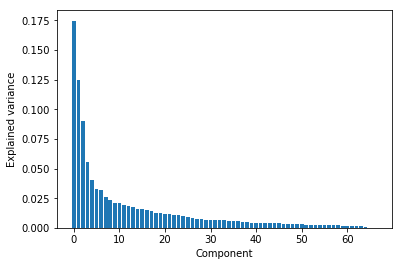

In [29]:
# Investigate the variance accounted for by each principal component.

plt.bar(np.arange(len(pca_values.explained_variance_ratio_)), pca_values.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained variance')


Text(0,0.5,'Cumulative explained variance')

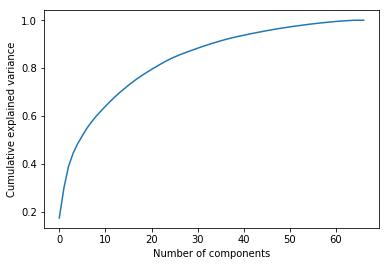

In [30]:
# Cumulative variance explained

cumulative = np.cumsum(pca_values.explained_variance_ratio_)
plt.plot(np.arange(len(pca_values.explained_variance_ratio_)), cumulative)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


In [31]:
# Re-apply PCA to the data while selecting for number of components to retain.

start_time = time.time()

pca2 = PCA(n_components = 30)
azdias_pca = pca2.fit_transform(azdias_scaled)

print('Run time: %s seconds' % (time.time() - start_time))


Run time: 29.020971298217773 seconds


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**For now I'm retaining a relatively high number of components (30). Finding the graphical 'elbow' in a PCA scree plot is usually a good way to decide how many components to keep, but to me this graph doesn't obviously show one 'major' elbow; instead there are a few places (e.g. around 5, 20, and 30) where the slope of the explained variance changes. One of the goals of PCA is to reduce the dimensions of the data, so using 30 components and reducing it by at least half seems like a reasonable choice.**

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [32]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_get_weights(pca, variable):
    df = pd.DataFrame(pca.components_, columns = list(azdias_scaled.columns))
    weights = df.iloc[variable].sort_values(ascending = False)
    return weights                      

pca_get_weights(pca2, 0)


PLZ8_ANTG3               0.227482
PLZ8_ANTG4               0.221490
PLZ8_BAUMAX              0.216827
WEALTH                   0.204237
ORTSGR_KLS9              0.199952
HH_EINKOMMEN_SCORE       0.199301
EWDICHTE                 0.197781
FINANZ_HAUSBAUER         0.168535
PLZ8_ANTG2               0.154604
KBA05_ANTG4              0.152498
ARBEIT                   0.143055
ANZ_HAUSHALTE_AKTIV      0.136576
RELAT_AB                 0.135691
KBA05_ANTG3              0.131943
FINANZ_SPARER            0.103266
REGIOTYP                 0.082009
SEMIO_PFLICHT            0.076081
SEMIO_REL                0.072795
SEMIO_RAT                0.062058
KKK                      0.056433
OST_WEST_KZ              0.054176
SEMIO_MAT                0.053492
SEMIO_FAM                0.052464
W_KEIT_KIND_HH           0.052338
SEMIO_TRADV              0.049998
SEMIO_KAEM               0.046033
SEMIO_KULT               0.041935
PLZ8_HHZ                 0.041646
FINANZ_UNAUFFAELLIGER    0.037487
ANZ_HH_TITEL  

In [33]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_get_weights(pca2, 1)


ALTERSKATEGORIE_GROB     0.265534
SEMIO_ERL                0.252916
FINANZ_VORSORGER         0.246942
SEMIO_LUST               0.195979
RETOURTYP_BK_S           0.164198
SEMIO_KRIT               0.126485
SEMIO_KAEM               0.118997
W_KEIT_KIND_HH           0.107558
ANREDE_KZ                0.104124
FINANZ_MINIMALIST        0.097883
FINANZ_HAUSBAUER         0.089014
SEMIO_DOM                0.079475
WOHNDAUER_2008           0.069509
EWDICHTE                 0.054408
ORTSGR_KLS9              0.052852
PLZ8_ANTG3               0.048429
PLZ8_ANTG4               0.045898
PLZ8_BAUMAX              0.041382
KBA05_ANTG4              0.039109
ARBEIT                   0.038532
RELAT_AB                 0.038372
ANZ_HAUSHALTE_AKTIV      0.036362
WEALTH                   0.034181
PLZ8_ANTG2               0.033960
LIFE_STAGE               0.025525
ANZ_HH_TITEL             0.024187
HH_EINKOMMEN_SCORE       0.018990
REGIOTYP                 0.018060
KBA05_ANTG3              0.015627
OST_WEST_KZ   

In [34]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_get_weights(pca2, 2)


SEMIO_VERT               0.343909
SEMIO_SOZ                0.255467
SEMIO_FAM                0.235814
SEMIO_KULT               0.220072
FINANZ_MINIMALIST        0.171063
RETOURTYP_BK_S           0.118428
FINANZ_VORSORGER         0.117349
W_KEIT_KIND_HH           0.095828
ALTERSKATEGORIE_GROB     0.092959
SEMIO_LUST               0.077571
GREEN_AVANTGARDE         0.056105
MOVEMENT                 0.056105
SEMIO_REL                0.049397
ORTSGR_KLS9              0.046958
EWDICHTE                 0.045993
PLZ8_BAUMAX              0.045439
PLZ8_ANTG4               0.043309
PLZ8_ANTG3               0.042207
SEMIO_MAT                0.040639
WOHNDAUER_2008           0.039993
ARBEIT                   0.033466
RELAT_AB                 0.030899
PLZ8_ANTG2               0.027741
KBA05_ANTG4              0.024341
ANZ_HAUSHALTE_AKTIV      0.022190
WEALTH                   0.021300
OST_WEST_KZ              0.013876
ANZ_HH_TITEL             0.013678
LP_LEBENSPHASE_FEIN      0.012895
ANZ_TITEL     

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**PCA 1: Three most positive: social status, household net income, and wealth (LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE, WEALTH). (Update: new most positive are PLZ8_ANTG3, PLZ8_ANTG4, and PLZ8_BAUMAX: all measures of large household size.) Three most negative: movement patterns, number of 1-2 family houses, and number of 1-2 family houses in the PLZ8 region (MOBI_REGIO, KBA05_ANTG1, PLZ8_ANTG1). (Update: no change.)**

**PCA 2: Three most positive: estimated age, financial preparation, and energy consumption (ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3). (Update: new most positive are ALTERSKATEGORIE_GROB, SEMIO_ERL: being event-oriented, and FINANZ_VORSORGER.) Three most negative: life stage, money saver, and religious (DECADE, FINANZ_SPARER, SEMIO_REL). (Update: new most negative are SEMIO_REL, FINANZ_SPARER, and SEMIO_TRADV: being traditional-minded.)**

**PCA 3: Three most positive: dreamful, family-minded, socially-minded (SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ). (Update: no change.) Three most negative: gender, combative, dominant-minded (ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM). (Update: no change.)**

**These components are at least partially interpretable in interesting ways. In the first component, measures of wealth and social status (update: large household sizes) are positively correlated with each other, and negatively correlated with movement and with small household sizes. The second component has positive correlations between age, financial preparation, and energy consumption (update: being event-oriented), though here the negatively-correlated variables are a little more difficult to interpret. The third component tracks social, personality, and gender indicators.**

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [35]:
# Over a number of different cluster counts, run k-means clustering on the data
# and compute the average within-cluster distances.   

def k_means_clustering(data, number_of_clusters):
    kmeans = KMeans(n_clusters = number_of_clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score
    

In [36]:
start_time = time.time()

scores = []
clusters = list(range(1, 20))

for i in clusters:
    scores.append(k_means_clustering(azdias_pca, i))

print('Run time: %s seconds' % (time.time() - start_time))


Run time: 2700.677332878113 seconds


Text(0,0.5,'Sum of squared errors')

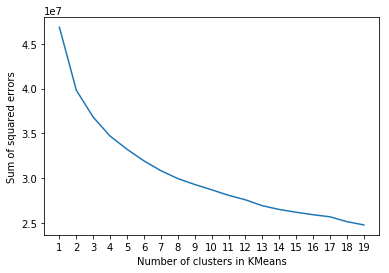

In [37]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(clusters, scores)
plt.xticks(range(1, 20))
plt.xlabel('Number of clusters in KMeans')
plt.ylabel('Sum of squared errors')


In [38]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

start_time = time.time()

number_of_clusters = 8
kmeans = KMeans(n_clusters = number_of_clusters)
model = kmeans.fit(azdias_pca)
azdias_predictions = model.predict(azdias_pca)

print('Run time: %s seconds' % (time.time() - start_time))


Run time: 67.63830327987671 seconds


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**For now I'm using 8 clusters. The graph shows that using more clusters reduces the sum of squared errors, with diminishing returns as the number of clusters increases, but to me there isn't a clear 'elbow'. Using 8 clusters seems like a reasonable compromise; it captures much of the benefits and doesn't take too much time to run.**

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [39]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [40]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

start_time = time.time()

# Apply cleaning function
clean_customer_data = clean_data(customers)

# Clean NaN values
customer_data_imputed = pd.DataFrame(imputer.fit_transform(clean_customer_data), columns = list(clean_customer_data))

# Apply feature scaling
customer_scaled = pd.DataFrame(scaler.transform(customer_data_imputed), columns = list(customer_data_imputed))

# Apply PCA
customer_pca = pca2.transform(customer_scaled)

# Cluster predictions
customer_predictions = model.predict(customer_pca)

print('Run time: %s seconds' % (time.time() - start_time))


Run time: 158.4778971672058 seconds


In [ ]:
#clean_customer_data.head()
#customer_scaled.head()


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General population predictions')

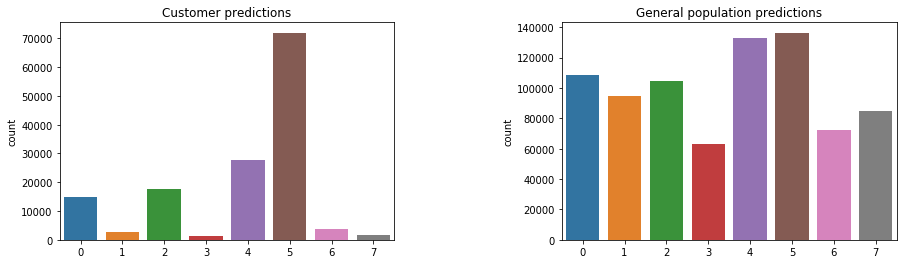

In [41]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(1, 2, figsize = (15, 4))
figure.subplots_adjust(hspace = 3, wspace = 0.5)

sns.countplot(customer_predictions, ax=axs[0])
axs[0].set_title('Customer predictions')

sns.countplot(azdias_predictions, ax=axs[1])
axs[1].set_title('General population predictions')


In [42]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Overrepresented: centroid 5?

overrepresented = scaler.inverse_transform(pca2.inverse_transform(model.cluster_centers_[5]))
pd.Series(data = overrepresented, index = customer_scaled.columns).sort_values(ascending = False)


MIN_GEBAEUDEJAHR         1993.674869
KBA13_ANZAHL_PKW          679.947849
DECADE                     65.255525
LP_LEBENSPHASE_FEIN        21.120626
WOHNDAUER_2008              8.396402
LP_LEBENSPHASE_GROB         6.198347
SEMIO_VERT                  6.014260
INNENSTADT                  5.419606
SEMIO_LUST                  5.012444
BALLRAUM                    4.870943
SEMIO_KULT                  4.811812
SEMIO_FAM                   4.708705
SEMIO_SOZ                   4.667582
FINANZ_MINIMALIST           4.655615
WOHNLAGE                    4.453688
SEMIO_ERL                   4.288280
FINANZ_VORSORGER            4.257047
ORTSGR_KLS9                 4.081107
W_KEIT_KIND_HH              4.067178
MOBI_REGIO                  4.061496
KBA05_GBZ                   4.058241
GEBAEUDETYP_RASTER          4.006313
RETOURTYP_BK_S              3.915183
PLZ8_GBZ                    3.868681
REGIOTYP                    3.832891
KONSUMNAEHE                 3.816802
SEMIO_REL                   3.645677
S

In [43]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Underrepresented: centroid 1?
underrepresented = scaler.inverse_transform(pca2.inverse_transform(model.cluster_centers_[1]))
pd.Series(data = underrepresented, index = customer_scaled.columns).sort_values(ascending = False)


MIN_GEBAEUDEJAHR         1994.019760
KBA13_ANZAHL_PKW          705.299033
DECADE                     81.625202
LP_LEBENSPHASE_FEIN        16.451824
WOHNDAUER_2008              7.512246
SEMIO_RAT                   6.020638
SEMIO_DOM                   5.950399
SEMIO_PFLICHT               5.895706
SEMIO_KAEM                  5.578050
SEMIO_TRADV                 5.555907
INNENSTADT                  5.426819
SEMIO_KRIT                  5.410086
SEMIO_REL                   5.107479
LP_LEBENSPHASE_GROB         5.072631
SEMIO_MAT                   4.951846
BALLRAUM                    4.923236
WOHNLAGE                    4.497277
SEMIO_ERL                   4.403635
FINANZ_ANLEGER              4.371958
ORTSGR_KLS9                 4.040705
HH_EINKOMMEN_SCORE          4.039262
GEBAEUDETYP_RASTER          3.963240
SEMIO_KULT                  3.956389
FINANZ_SPARER               3.948749
PLZ8_GBZ                    3.910062
FINANZ_UNAUFFAELLIGER       3.871818
REGIOTYP                    3.816493
K

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**The population segments are somewhat difficult to describe using the scoring methodologies of the data dictionary. One interpretation is that, compared to the general population, mail-order customers tend to be less socially-minded and less cultural-minded, and more critical, combative, and dominant. (They score high, meaning they have relatively low affinities, on SEMIO_SOZ and SEMIO_KULT in the 'overrepresented' analysis. In the 'underrepresented' analysis, they score low, meaning they have relatively high affinities, on SEMIO_KRIT, SEMIO_KAEM, and SEMIO_DOM.) I would be cautious with these interpretations, however; the methodologies generate complex combinations of different variables. For example, distance to city center (INNENSTADT) is positively correlated in both the 'overrepresented' and the 'underrepresented' centroids.**


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.